# Customer Churn

## Goal: 
* Determine the cause of customers churning
* Build a model that will predict reasons why customers might be churning


#### ----------------------------------------Imports----------------------------------------


In [1]:
from env import get_connection
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
from scipy import stats
# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

# import our own acquire module
import acquire
#import my own prepare module
import prepare
# import my own function module
import function

#### ----------------------------------------Acquiring the data----------------------------------------

In [2]:
df = acquire.get_telco_data()

#### ----------------------------------------Checking the data----------------------------------------

In [3]:
df.head()

,Unnamed: 0,payment_type_id,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,0,2,2,1,0002-ORFBO,Female,0,Yes,Yes,9,...,Yes,Yes,No,Yes,65.6,593.3,No,DSL,One year,Mailed check
1,1,2,1,1,0003-MKNFE,Male,0,No,No,9,...,No,No,Yes,No,59.9,542.4,No,DSL,Month-to-month,Mailed check
2,2,1,1,2,0004-TLHLJ,Male,0,No,No,4,...,No,No,No,Yes,73.9,280.85,Yes,Fiber optic,Month-to-month,Electronic check
3,3,1,1,2,0011-IGKFF,Male,1,Yes,No,13,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Fiber optic,Month-to-month,Electronic check
4,4,2,1,2,0013-EXCHZ,Female,1,Yes,No,3,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Fiber optic,Month-to-month,Mailed check


#### ----------------------------------------Familiarizing myself with the dataset to know what I'm dealing with----------------------------------------

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                7043 non-null   int64  
 1   payment_type_id           7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   internet_service_type_id  7043 non-null   int64  
 4   customer_id               7043 non-null   object 
 5   gender                    7043 non-null   object 
 6   senior_citizen            7043 non-null   int64  
 7   partner                   7043 non-null   object 
 8   dependents                7043 non-null   object 
 9   tenure                    7043 non-null   int64  
 10  phone_service             7043 non-null   object 
 11  multiple_lines            7043 non-null   object 
 12  online_security           7043 non-null   object 
 13  online_backup             7043 non-null   object 
 14  device_p

#### ----------------------------------------Dropping unnecessary columns----------------------------------------

In [5]:
df.drop(columns = ['Unnamed: 0', 'payment_type_id', 'contract_type_id', 'customer_id', 
                   'gender', 'senior_citizen', 'partner', 'dependents', 'phone_service', 
                   'multiple_lines', 'streaming_tv', 'streaming_movies', 'contract_type', 
                   'payment_type', 'paperless_billing', 'internet_service_type_id'], inplace = True)


#### ----------------------------------------Checking to see my remaining columns----------------------------------------

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tenure                 7043 non-null   int64  
 1   online_security        7043 non-null   object 
 2   online_backup          7043 non-null   object 
 3   device_protection      7043 non-null   object 
 4   tech_support           7043 non-null   object 
 5   monthly_charges        7043 non-null   float64
 6   total_charges          7043 non-null   object 
 7   churn                  7043 non-null   object 
 8   internet_service_type  7043 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 495.3+ KB


#### ----------------------------------------Checking how many customers have churned----------------------------------------

In [7]:
pd.DataFrame(df.churn.value_counts())

,churn
No,5174
Yes,1869


- 1869, or 26.5% of customers have churned 

#### ----------------------------------------Checking to see how many customers have DSL, fiber and no internet service----------------------------------------

In [8]:
df.internet_service_type.value_counts()

Fiber optic    3096
DSL            2421
None           1526
Name: internet_service_type, dtype: int64

#### ----------------------------------------Checking to see if there are any null values in the dataset----------------------------------------

In [9]:
df.isna().any()

tenure                   False
online_security          False
online_backup            False
device_protection        False
tech_support             False
monthly_charges          False
total_charges            False
churn                    False
internet_service_type    False
dtype: bool

#### ----------------------------------------Using describe to get a feel of some of the data----------------------------------------

In [10]:
df.describe()

,tenure,monthly_charges
count,7043.000000,7043.000000
mean,32.371149,64.761692
std,24.559481,30.090047
min,0.000000,18.250000
25%,9.000000,35.500000
50%,29.000000,70.350000
75%,55.000000,89.850000
max,72.000000,118.750000


#### ----------------------------------------Preparing the data----------------------------------------
 - removing all whitespace from total charges to convert to a float

In [11]:
df.total_charges = df.total_charges.str.strip()

* reassigning the dataframe to remove rows with no value

In [12]:
df = df[df.total_charges != ""]

* reassigning the total_charges column from a str to a float

In [13]:
df.total_charges = df.total_charges.astype(float)

* Getting info to see what columns are object to creat dummies for binary readability

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tenure                 7032 non-null   int64  
 1   online_security        7032 non-null   object 
 2   online_backup          7032 non-null   object 
 3   device_protection      7032 non-null   object 
 4   tech_support           7032 non-null   object 
 5   monthly_charges        7032 non-null   float64
 6   total_charges          7032 non-null   float64
 7   churn                  7032 non-null   object 
 8   internet_service_type  7032 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 549.4+ KB


#### ----------------------------------------Creating dummy variables for the columns that were object datatypes----------------------------------------

In [15]:
dummy_df = pd.get_dummies(df[['online_security','online_backup', 'device_protection', 
                        'tech_support', 'churn', 'internet_service_type']], dummy_na=False, drop_first=[True, True])
dummy_df.head()


,online_security_No internet service,online_security_Yes,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,churn_Yes,internet_service_type_Fiber optic,internet_service_type_None
0,0,0,0,1,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,1,1,0
3,0,0,0,1,0,1,0,0,1,1,0
4,0,0,0,0,0,0,0,1,1,1,0


#### ----------------------------------------Combining the original df with the dummy variables that were created----------------------------------------


In [16]:
df = pd.concat([df, dummy_df], axis=1)
df.head(1)

,tenure,online_security,online_backup,device_protection,tech_support,monthly_charges,total_charges,churn,internet_service_type,online_security_No internet service,online_security_Yes,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,churn_Yes,internet_service_type_Fiber optic,internet_service_type_None
0,9,No,Yes,No,Yes,65.6,593.3,No,DSL,0,0,0,1,0,0,0,1,0,0,0


In [17]:
df.drop(columns = ['online_security','online_backup', 'device_protection', 
                        'tech_support', 'churn', 'internet_service_type'], inplace = True)


In [18]:
df.head()

,tenure,monthly_charges,total_charges,online_security_No internet service,online_security_Yes,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,churn_Yes,internet_service_type_Fiber optic,internet_service_type_None
0,9,65.6,593.30,0,0,0,1,0,0,0,1,0,0,0
1,9,59.9,542.40,0,0,0,0,0,0,0,0,0,0,0
2,4,73.9,280.85,0,0,0,0,0,1,0,0,1,1,0
3,13,98.0,1237.85,0,0,0,1,0,1,0,0,1,1,0
4,3,83.9,267.40,0,0,0,0,0,0,0,1,1,1,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 7032 non-null   int64  
 1   monthly_charges                        7032 non-null   float64
 2   total_charges                          7032 non-null   float64
 3   online_security_No internet service    7032 non-null   uint8  
 4   online_security_Yes                    7032 non-null   uint8  
 5   online_backup_No internet service      7032 non-null   uint8  
 6   online_backup_Yes                      7032 non-null   uint8  
 7   device_protection_No internet service  7032 non-null   uint8  
 8   device_protection_Yes                  7032 non-null   uint8  
 9   tech_support_No internet service       7032 non-null   uint8  
 10  tech_support_Yes                       7032 non-null   uint8  
 11  chur

#### ----------------------------------------Making all the columns lowercase----------------------------------------

In [20]:
df.columns = df.columns.str.lower()
df.head()

,tenure,monthly_charges,total_charges,online_security_no internet service,online_security_yes,online_backup_no internet service,online_backup_yes,device_protection_no internet service,device_protection_yes,tech_support_no internet service,tech_support_yes,churn_yes,internet_service_type_fiber optic,internet_service_type_none
0,9,65.6,593.30,0,0,0,1,0,0,0,1,0,0,0
1,9,59.9,542.40,0,0,0,0,0,0,0,0,0,0,0
2,4,73.9,280.85,0,0,0,0,0,1,0,0,1,1,0
3,13,98.0,1237.85,0,0,0,1,0,1,0,0,1,1,0
4,3,83.9,267.40,0,0,0,0,0,0,0,1,1,1,0


#### ----------------------------------------Splitting the data----------------------------------------

In [21]:
train, validate, test = prepare.train_val_test(df, 'churn_yes')


#### ----------------------------------------Checking the size of the train, validate and test datasets----------------------------------------

In [22]:
train.shape, validate.shape, test.shape

((4922, 14), (1688, 14), (422, 14))

#### ----------------------------------------Creating a varriable dataframe for nonbinary values and churn count----------------------------------------

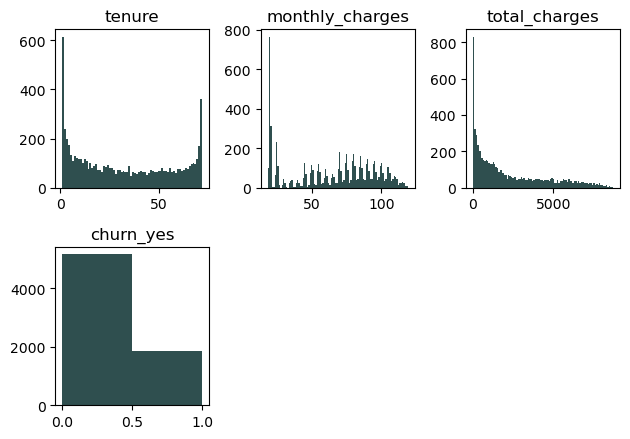

In [23]:
df_nonbinary= df[['tenure', 'monthly_charges', 'total_charges', 'churn_yes']]

for i in range(df_nonbinary.shape[1]):
    plt.subplot(6, 3, i + 1)
    f = plt.gca()
    f.set_title(df_nonbinary.columns.values[i])

    vals = np.size(df_nonbinary.iloc[:, i].unique())
    if vals >= 100:
        vals = 100
    
    plt.hist(df_nonbinary.iloc[:, i], bins=vals, color = 'darkslategray')
plt.tight_layout(rect=[0, 0.3, 1, 3])

# Price T-Test

### Establishing my hypothesis for my T-Test
- H
0
: Mean of monthly charges of churned customers <= Mean of monthly charges of customers who haven't churned
- H
a
: Mean of monthly charges of churned customers > Mean of monthly charges of customers who haven't churned

<AxesSubplot:>

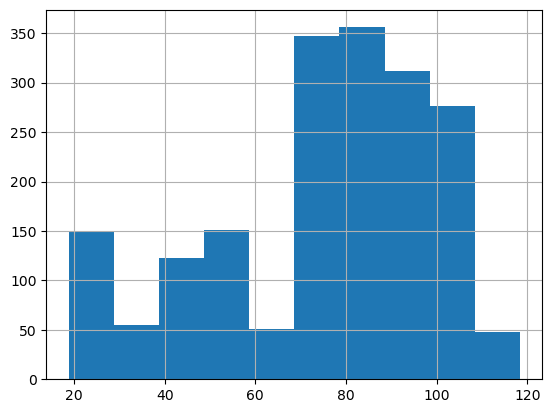

In [24]:
churned_price = df[df.churn_yes == True].monthly_charges

churned_price.hist()

<AxesSubplot:>

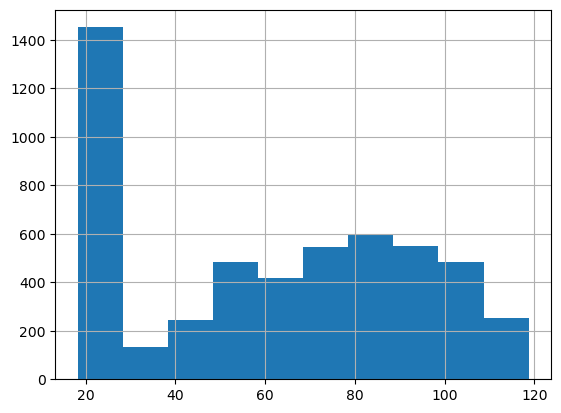

In [25]:
churn_no_price = df[df.churn_yes == False].monthly_charges

churn_no_price.hist()

In [26]:
# create bins of equal intervals
monthly_charges_bins = pd.cut(df.monthly_charges, 5)

<AxesSubplot:xlabel='monthly_charges', ylabel='count'>

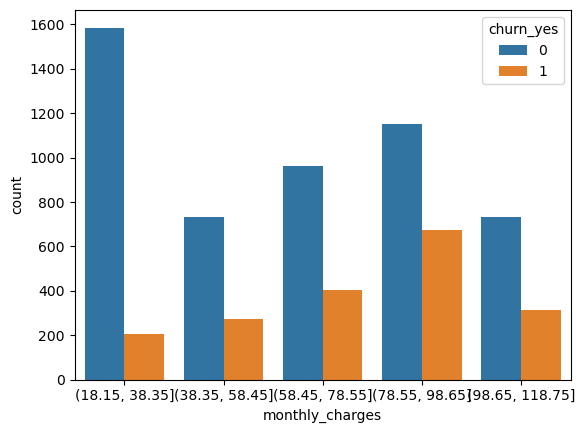

In [27]:
sns.countplot(hue = df.churn_yes, x = monthly_charges_bins, data=df)

<AxesSubplot:xlabel='churn_yes', ylabel='monthly_charges'>

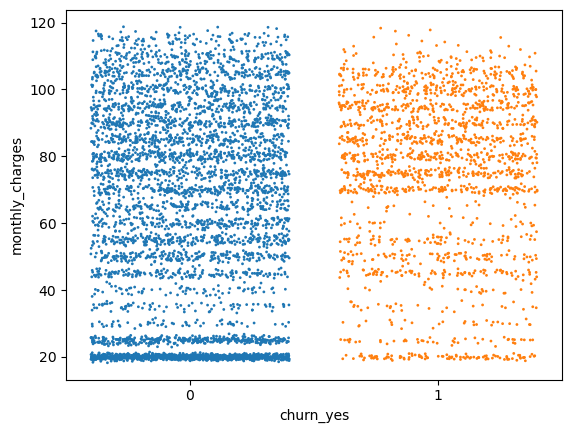

In [28]:
sns.stripplot(y=df.monthly_charges, x=df.churn_yes, data=df, size = 2, jitter = .4)

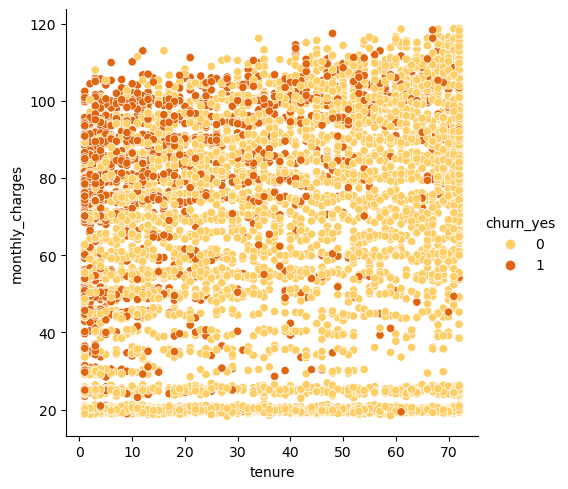

In [29]:
sns.relplot(df.tenure, df.monthly_charges, hue = 'churn_yes', data = df, palette = 'YlOrBr')

In [30]:
alpha = .05

In [31]:
print(churned_price.var())
print(churn_no_price.var())

608.4141833954315
966.8714692223


In [32]:
t, p = stats.ttest_ind(churned_price, churn_no_price, equal_var=False)
t, p / 2

(18.34091879095257, 1.3286785722580138e-72)

In [33]:
print("is p/2 < alpha? ", p / 2 < alpha)
print("is t > 0? ", t > 0)


is p/2 < alpha?  True
is t > 0?  True


In [34]:
if p / 2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")


We reject $H_{0}$


# Tenure T-Test

- H
0
: Length of tenure of churned customers >= length of tenure of customers who haven't churned
- H
a
: Length of tenure of churned customers < length of tenure of customers who haven't churned

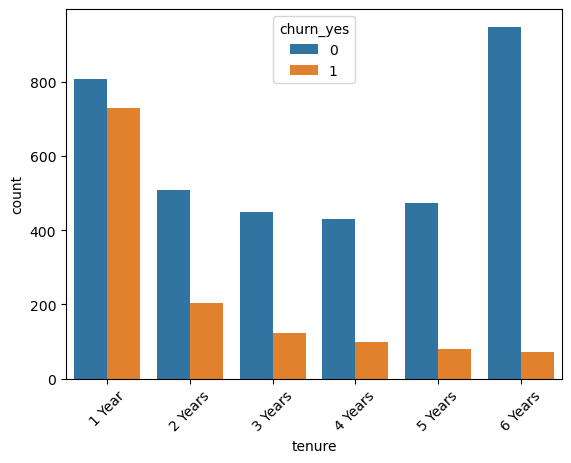

In [131]:
tenure_bins = pd.cut(train.tenure, 6, precision = 0)
tenure_bins.value_counts()
labels = ['1 Year', '2 Years', '3 Years', '4 Years', '5 Years', '6 Years']

sns.countplot(hue = train.churn_yes, x = tenure_bins, data = train)
plt.xticks(ticks = (0, 1, 2, 3, 4, 5), rotation = 45, labels = labels)

plt.show()

In [132]:
train.groupby('churn_yes')['tenure'].mean()

churn_yes
0    37.733536
1    18.124618
Name: tenure, dtype: float64

<AxesSubplot:>

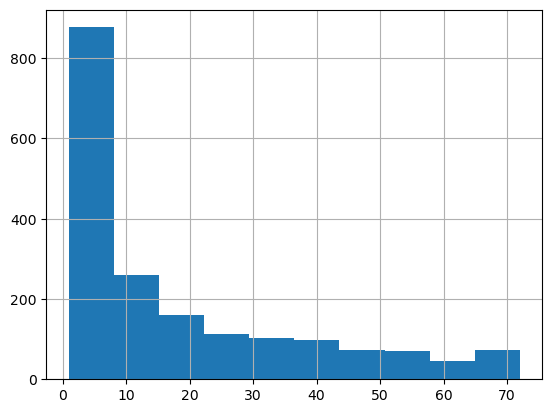

In [38]:
churned_tenure = df[df.churn_yes == True].tenure

churned_tenure.hist()

<AxesSubplot:>

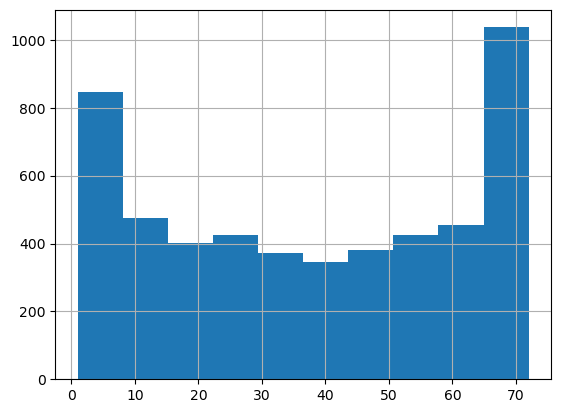

In [39]:
churned_no_tenure = df[df.churn_yes == False].tenure

churned_no_tenure.hist()

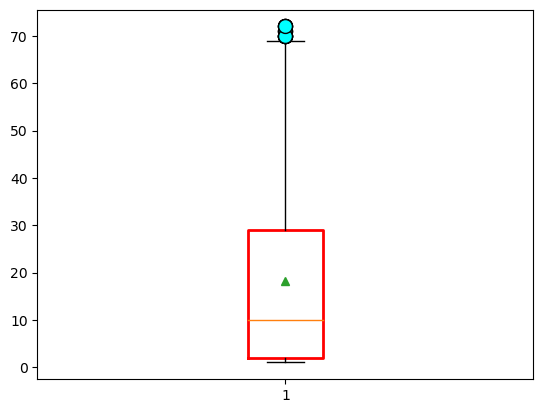

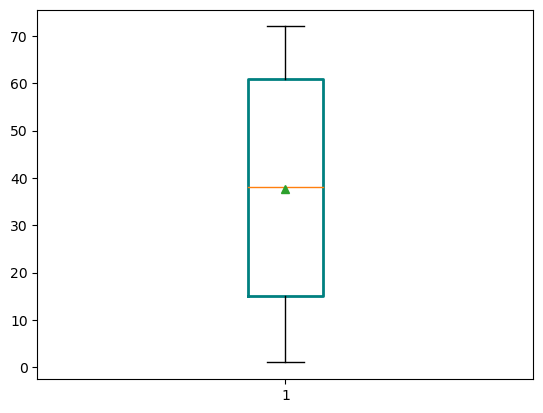

In [133]:
boxprops1 = dict(linestyle='-', linewidth=2, color='red')
boxprops2 = dict(linestyle='-', linewidth=2, color='teal')
flierprops = dict(marker='o', markerfacecolor='cyan', markersize=10, linestyle='none')

plt.boxplot(train.tenure[train.churn_yes == True], showmeans = True, 
            boxprops = boxprops1, flierprops = flierprops)
plt.show()

plt.boxplot(train.tenure[train.churn_yes == False], showmeans = True, 
            boxprops = boxprops2)
plt.show()

In [41]:
print(churned_tenure.var())
print(churned_no_tenure.var())


381.4647677707878
579.6990638317577


In [42]:
t, p = stats.ttest_ind(churned_tenure, churned_no_tenure, equal_var=False)
t, p / 2

(-34.971870097503476, 1.1735373594477435e-234)

In [43]:
print("is p/2 < alpha? ", p / 2 < alpha)
print("is t > 0? ", t > 0)


is p/2 < alpha?  True
is t > 0?  False


In [109]:
if p / 2 > alpha:
    print("We fail to reject $H_{0}$")
elif t > 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

We reject $H_{0}$


# Customer Support (Tech Support)

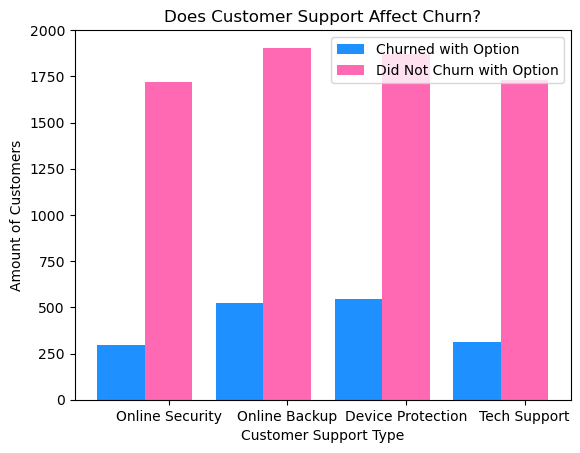

<function matplotlib.pyplot.show(close=None, block=None)>

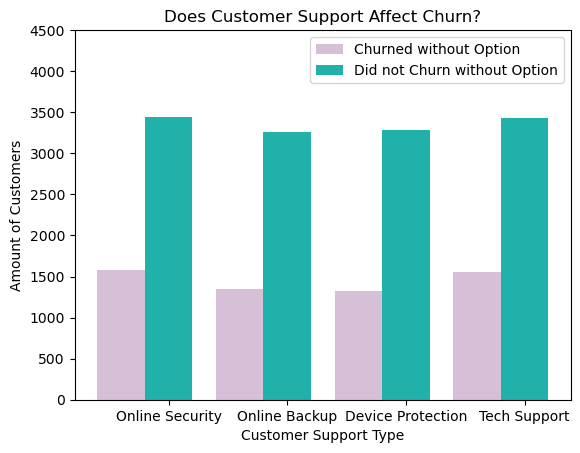

In [45]:
cust_sppt_churned = (295, 523, 545, 310)
cust_sppt_no_churned = (1720, 1902, 1873, 1730)

customer_support = ('Online Security', 'Online Backup', 'Device Protection', 'Tech Support')

width = 0.4
index = np.arange(4)
plt.bar(index, cust_sppt_churned, width = width, 
        label = 'Churned with Option', color = 'dodgerblue')
plt.bar(index + width, cust_sppt_no_churned, width = width, 
        label = 'Did Not Churn with Option', color = 'hotpink')

plt.xticks(index + width, customer_support)
plt.ylim (0, 2000)
plt.title('Does Customer Support Affect Churn?')
plt.ylabel('Amount of Customers')
plt.xlabel('Customer Support Type')
plt.legend()
plt.show()

no_cust_sppt_no_churn = (3443, 3261, 3290, 3433)
no_cust_sppt_churn = (1574, 1346, 1324, 1559)

plt.bar(index, no_cust_sppt_churn, width = width, 
        label = 'Churned without Option', color = 'thistle')
plt.bar(index + width, no_cust_sppt_no_churn, width = width, 
        label = 'Did not Churn without Option', color = 'lightseagreen')


plt.xticks(index + width, customer_support)
plt.ylim (0, 4500)
plt.title('Does Customer Support Affect Churn?')
plt.ylabel('Amount of Customers')
plt.xlabel('Customer Support Type')
plt.legend()
plt.show

<AxesSubplot:xlabel='tech_support_yes', ylabel='count'>

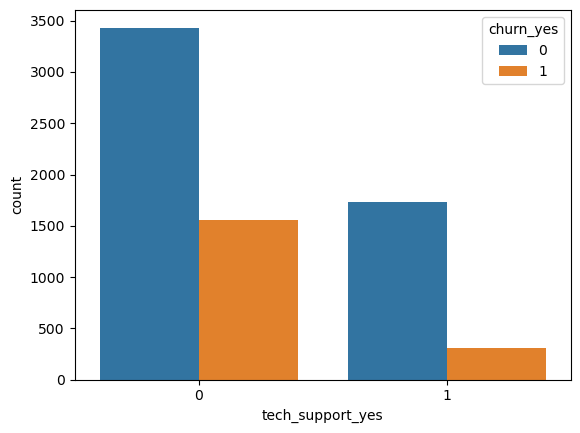

In [46]:
sns.countplot(df['tech_support_yes'], hue = df.churn_yes)

#### Running Chi**2 test on my binary values

In [134]:
tech_sppt = pd.crosstab(train.churn_yes, train.tech_support_yes)
tech_sppt

tech_support_yes,0,1
churn_yes,,
0,2399,1215
1,1090,218


In [135]:
chi2, p, degf, expected = stats.chi2_contingency(tech_sppt)


In [136]:
# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(tech_sppt.values)

# print --- and then a new line, 'Expected Values', followed by another new line
print('---\nExpected Values\n')

# print the expected values array
print(expected.astype(int))

# print a new line
print('---\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2:.4f}') 

# print the p-value, formatted to a float with 4 digits. 
print(f'p     = {p:.4f}')


Observed Values

[[2399 1215]
 [1090  218]]
---
Expected Values

[[2561 1052]
 [ 927  380]]
---

chi^2 = 132.9202
p     = 0.0000


In [137]:
fiber = pd.crosstab(train.churn_yes, train['internet_service_type_fiber optic'])
fiber

internet_service_type_fiber optic,0,1
churn_yes,,
0,2369,1245
1,398,910


In [138]:
chi2, p, degf, expected = stats.chi2_contingency(fiber)

In [52]:
# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(fiber.values)

# print --- and then a new line, 'Expected Values', followed by another new line
print('---\nExpected Values\n')

# print the expected values array
print(expected.astype(int))

# print a new line
print('---\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2:.4f}') 

# print the p-value, formatted to a float with 4 digits. 
print(f'p     = {p:.4f}')


Observed Values

[[3364 1799]
 [ 572 1297]]
---
Expected Values

[[2889 2273]
 [1046  822]]
---

chi^2 = 663.3565
p     = 0.0000


In [139]:
no_internet = pd.crosstab(df.churn_yes, df.internet_service_type_none)
no_internet

internet_service_type_none,0,1
churn_yes,,
0,3756,1407
1,1756,113


In [140]:
chi2, p, degf, expected = stats.chi2_contingency(no_internet)

In [55]:
# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(no_internet.values)

# print --- and then a new line, 'Expected Values', followed by another new line
print('---\nExpected Values\n')

# print the expected values array
print(expected.astype(int))

# print a new line
print('---\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2:.4f}') 

# print the p-value, formatted to a float with 4 digits. 
print(f'p     = {p:.4f}')


Observed Values

[[3756 1407]
 [1756  113]]
---
Expected Values

[[4046 1116]
 [1465  403]]
---

chi^2 = 362.9478
p     = 0.0000


# A 'p' value of 0 means the null hypothesis is rejected and your test is statistically significant (for example the differences between your groups are significant).

<AxesSubplot:xlabel='internet_service_type_fiber optic', ylabel='count'>

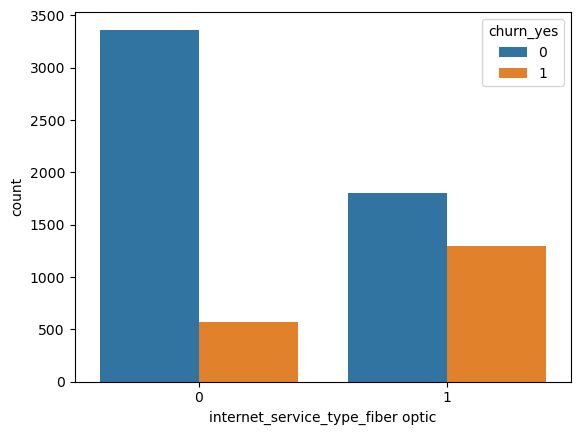

In [56]:
sns.countplot(df['internet_service_type_fiber optic'], hue = df.churn_yes)

<AxesSubplot:xlabel='internet_service_type_none', ylabel='count'>

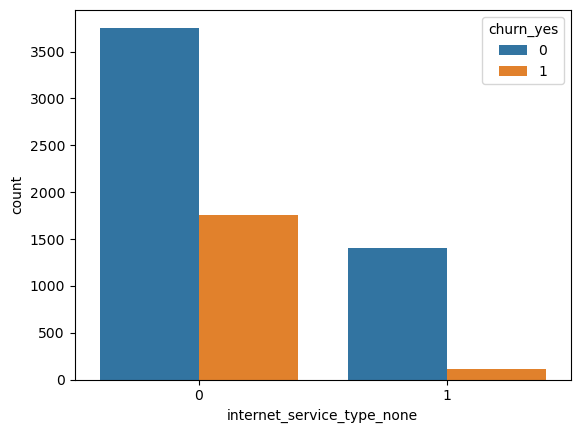

In [57]:
sns.countplot(df['internet_service_type_none'], hue = df.churn_yes)

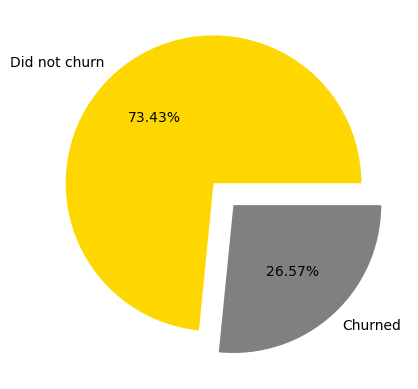

In [142]:
values = (3614, 1308)
labels = ('Did not churn', 'Churned')
plt.pie(values, labels = ('Did not churn', 'Churned'), autopct = "%.2f%%", explode = (0.1, 0.1), colors = ('gold', 'gray'))
plt.show()

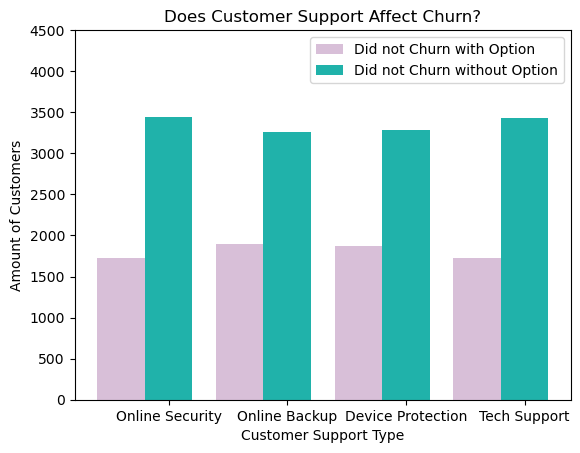

In [62]:
cust_sppt_no_churned = (1720, 1902, 1873, 1730)
no_cust_sppt_no_churn = (3443, 3261, 3290, 3433)


customer_support = ('Online Security', 'Online Backup', 'Device Protection', 'Tech Support')

width = 0.4
index = np.arange(4)
plt.bar(index, cust_sppt_no_churned, width = width, 
        label = 'Did not Churn with Option', color = 'thistle')
plt.bar(index + width, no_cust_sppt_no_churn, width = width, 
        label = 'Did not Churn without Option', color = 'lightseagreen')


plt.xticks(index + width, customer_support)
plt.ylim (0, 4500)
plt.title('Does Customer Support Affect Churn?')
plt.ylabel('Amount of Customers')
plt.xlabel('Customer Support Type')
plt.legend()

# Baseline Model

In [63]:
baseline_df = pd.DataFrame({'actual': df.churn_yes == True, 
                            'prediction': df.churn_yes == True})
baseline_df


,actual,prediction
0,False,False
1,False,False
2,True,True
3,True,True
4,True,True
...,...,...
7038,False,False
7039,True,True
7040,False,False
7041,False,False


In [64]:
pd.crosstab(baseline_df.actual, baseline_df.prediction)


prediction,False,True
actual,,
False,5163,0
True,0,1869


In [65]:
baseline_df['baseline_prediction'] = False

In [143]:
baseline_df

,actual,prediction,baseline_prediction
0,False,False,False
1,False,False,False
2,True,True,False
3,True,True,False
4,True,True,False
...,...,...,...
7038,False,False,False
7039,True,True,False
7040,False,False,False
7041,False,False,False


In [67]:
baseline_accuracy = (baseline_df.baseline_prediction == baseline_df.actual).mean()

print(f'baseline accuracy: {baseline_accuracy:.2%}')

baseline accuracy: 73.42%


# Decision Tree Model

In [68]:
X_train = train.drop(columns=['churn_yes'])
y_train = train.churn_yes

X_validate = validate.drop(columns=['churn_yes'])
y_validate = validate.churn_yes

X_test = test.drop(columns=['churn_yes'])
y_test = test.churn_yes

In [69]:
# for classification you can change the algorithm to gini or entropy (information gain).  
# Default is gini.

clf = DecisionTreeClassifier(max_depth=3, random_state=123)


In [70]:
# model.fit(X, y)

clf = clf.fit(X_train, y_train)


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 7032 non-null   int64  
 1   monthly_charges                        7032 non-null   float64
 2   total_charges                          7032 non-null   float64
 3   online_security_no internet service    7032 non-null   uint8  
 4   online_security_yes                    7032 non-null   uint8  
 5   online_backup_no internet service      7032 non-null   uint8  
 6   online_backup_yes                      7032 non-null   uint8  
 7   device_protection_no internet service  7032 non-null   uint8  
 8   device_protection_yes                  7032 non-null   uint8  
 9   tech_support_no internet service       7032 non-null   uint8  
 10  tech_support_yes                       7032 non-null   uint8  
 11  chur

In [72]:
clf.classes_

array([0, 1], dtype=uint8)

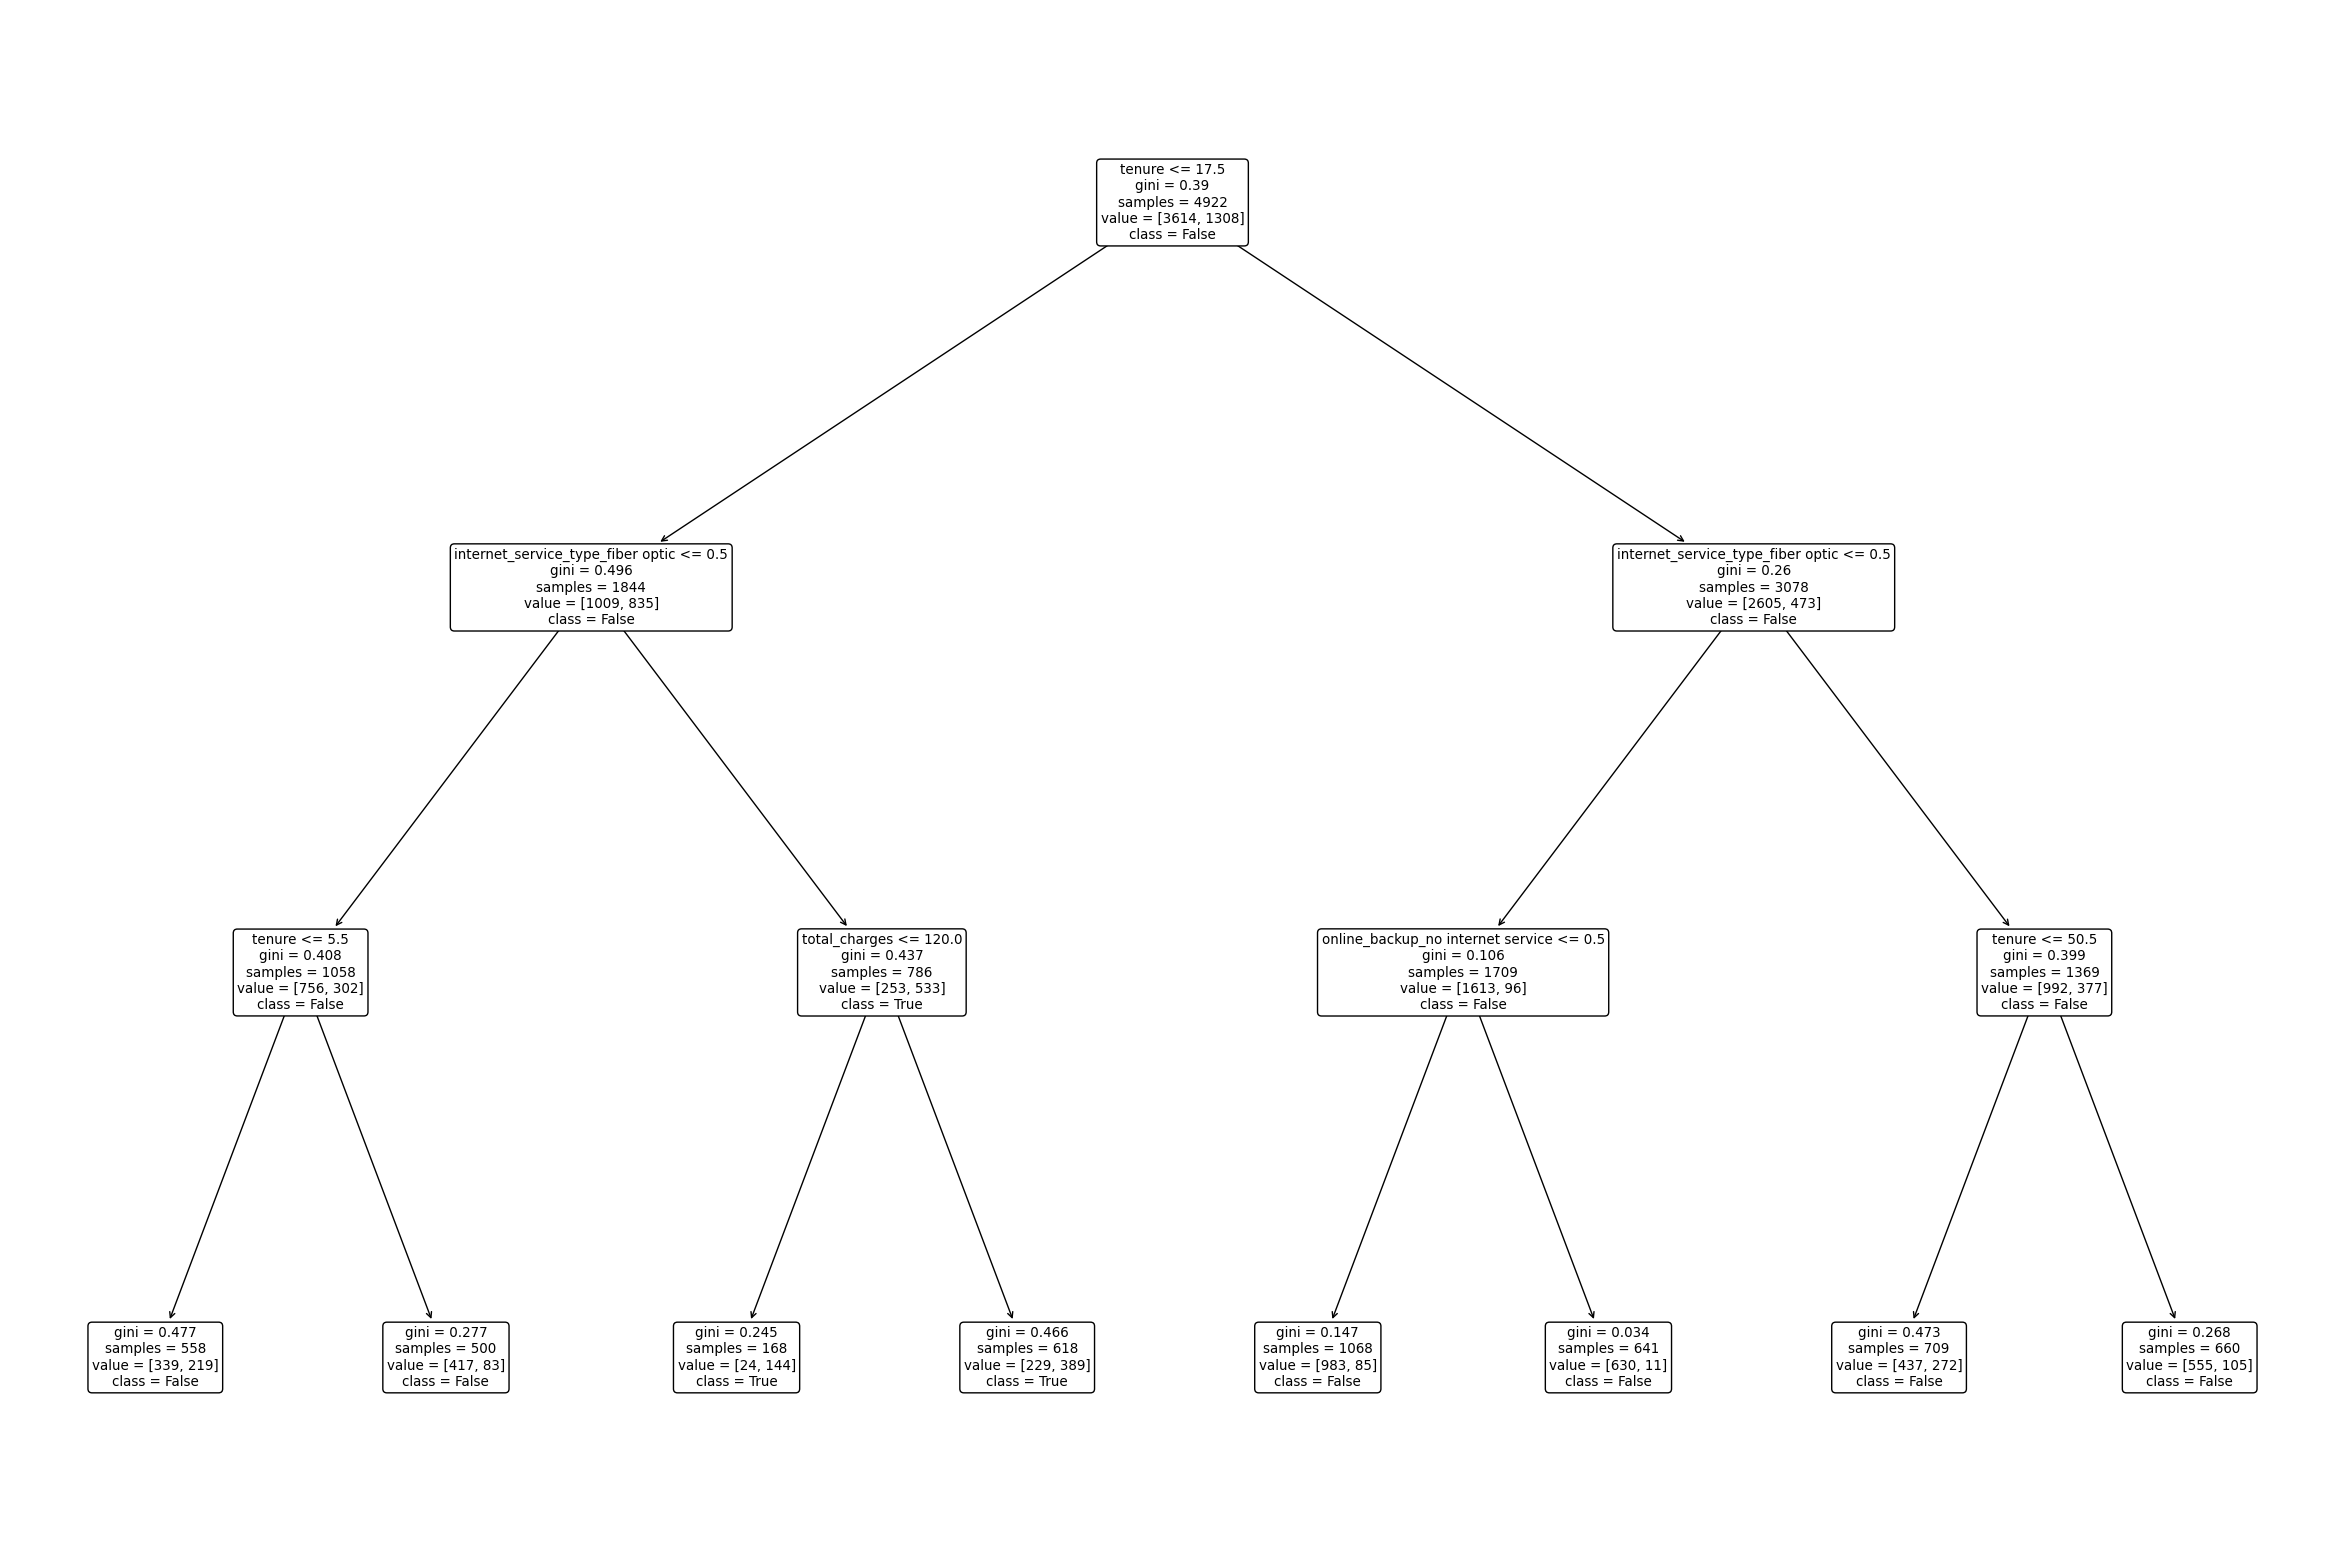

In [73]:
plt.figure(figsize=(30, 20))
plot_tree(clf, feature_names=X_train.columns, class_names=['False', 'True'], rounded=True)
plt.show()

In [74]:
# make prediction on train obeservations

y_pred = clf.predict(X_train)
y_pred[0:5]


array([1, 0, 0, 0, 0], dtype=uint8)

In [75]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.37055016, 0.62944984],
       [0.98283931, 0.01716069],
       [0.834     , 0.166     ],
       [0.84090909, 0.15909091],
       [0.84090909, 0.15909091]])

In [76]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))


Accuracy of Decision Tree classifier on training set: 0.79


In [77]:
# confusion matrix

confusion_matrix(y_train, y_pred)


array([[3361,  253],
       [ 775,  533]])

In [78]:
y_train.value_counts()


0    3614
1    1308
Name: churn_yes, dtype: int64

In [79]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)


,0,1
0,3361,253
1,775,533


In [80]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.93      0.87      3614
           1       0.68      0.41      0.51      1308

    accuracy                           0.79      4922
   macro avg       0.75      0.67      0.69      4922
weighted avg       0.78      0.79      0.77      4922



In [81]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))


Accuracy of Decision Tree classifier on validate set: 0.79


In [82]:
# And since accuracy isn't everything

# Produce y_predictions that come from the X_validate
y_pred = clf.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1239
           1       0.68      0.41      0.52       449

    accuracy                           0.79      1688
   macro avg       0.75      0.67      0.69      1688
weighted avg       0.78      0.79      0.77      1688



# RANDOM FOREST MODEL


In [83]:
X_train_rf = train.drop(columns=['churn_yes'])
y_train_rf = train.churn_yes

X_validate_rf = validate.drop(columns=['churn_yes'])
y_validate_rf = validate.churn_yes

X_test_rf = test.drop(columns=['churn_yes'])
y_test_rf = test.churn_yes

In [84]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)


In [85]:
rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [86]:
print(rf.feature_importances_)

[0.29404133 0.06844447 0.11973404 0.04336502 0.0523073  0.03814066
 0.01675167 0.04391832 0.01054735 0.03387568 0.062817   0.18719075
 0.02886642]


In [87]:
y_pred_rf = rf.predict(X_train_rf)

In [88]:
y_pred_proba_rf = rf.predict_proba(X_train_rf)

In [89]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train_rf, y_train_rf)))

Accuracy of random forest classifier on training set: 0.79


In [90]:
print(confusion_matrix(y_train_rf, y_pred_rf))

[[3406  208]
 [ 824  484]]


In [91]:
print(classification_report(y_train_rf, y_pred_rf))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      3614
           1       0.70      0.37      0.48      1308

    accuracy                           0.79      4922
   macro avg       0.75      0.66      0.68      4922
weighted avg       0.78      0.79      0.77      4922



In [92]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate_rf, y_validate_rf)))

Accuracy of random forest classifier on test set: 0.79


In [93]:
y_pred_rf = clf.predict(X_validate_rf)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate_rf, y_pred_rf))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1239
           1       0.68      0.41      0.52       449

    accuracy                           0.79      1688
   macro avg       0.75      0.67      0.69      1688
weighted avg       0.78      0.79      0.77      1688



# Logistic Regression Model


In [94]:
X_train_LR = train.drop(columns=['churn_yes'])
y_train_LR = train.churn_yes

X_validate_LR = validate.drop(columns=['churn_yes'])
y_validate_LR = validate.churn_yes

X_test_LR = test.drop(columns=['churn_yes'])
y_test_LR = test.churn_yes

In [95]:
# from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')


In [96]:
logit.fit(X_train_LR, y_train_LR)


LogisticRegression(C=1, class_weight={0: 1, 1: 99}, random_state=123)

In [97]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)


Coefficient: 
 [[-5.17750421e-02  4.20723933e-02  8.83416803e-05 -1.75543426e-01
  -6.18718491e-01 -1.75543426e-01 -1.97216049e-02 -1.75543426e-01
  -3.62301273e-01 -1.75543426e-01 -1.02128208e+00 -7.46514119e-01
  -1.75543426e-01]]
Intercept: 
 [2.97498856]


In [98]:
y_pred = logit.predict(X_train_LR)


In [99]:
y_pred_proba = logit.predict_proba(X_train_LR)


In [100]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train_LR, y_train_LR)))


Accuracy of Logistic Regression classifier on training set: 0.31


In [101]:
print(confusion_matrix(y_train_LR, y_pred))


[[ 216 3398]
 [   2 1306]]


In [102]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.06      0.11      3614
           1       0.28      1.00      0.43      1308

    accuracy                           0.31      4922
   macro avg       0.63      0.53      0.27      4922
weighted avg       0.80      0.31      0.20      4922



<AxesSubplot:xlabel='monthly_charges', ylabel='churn_yes'>

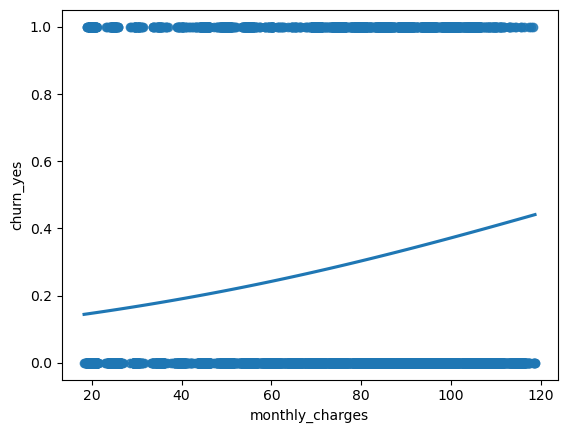

In [103]:
x = df.monthly_charges
y = df.churn_yes

#plot logistic regression curve
sns.regplot(x=x, y=y, data=df, logistic=True, ci=None)

# Making the prediction.csv file

In [ ]:
y_pred = clf.predict(X_test)
pred_df = pd.DataFrame(y_pred)

y_pred_proba = clf.predict_proba(X_test)
proba_df = pd.DataFrame(y_pred_proba)
proba_df = proba_df.drop(columns = 0)

df = acquire.get_telco_data()

X_train = train.drop(columns=['churn_yes'])
y_train = train.churn_yes

X_validate = validate.drop(columns=['churn_yes'])
y_validate = validate.churn_yes

X_test = test.drop(columns=['churn_yes', 'customer_id'])
y_test = test.churn_yes

cust_df = pd.DataFrame(test.customer_id)

cust_df.reset_index(inplace = True)

predictions = pd.concat([pred_df, proba_df, cust_df], axis = 1)
predictions = predictions.drop(columns = 'index')
predictions = predictions.rename(columns = {0:'prediction', 1:'probability'})

predictions

predictions.to_csv('predictions.csv')